##### Purpose of the notebook ####

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from scipy.sparse import csr_matrix, issparse
from scvelo import logging as logg
from scvelo import settings
from scvelo.preprocessing.neighbors import get_connectivities, get_n_neighs, neighbors, verify_neighbors
from scvelo.preprocessing.utils import normalize_per_cell, not_yet_normalized
import infercnvpy as cnv
import matplotlib

# Read adata

In [3]:
saving_path='/media/sergio/GBX/5KXenium/processed/5k_lymph_node'
adata=sc.read(os.path.join(saving_path,'adata_annotated.h5ad'))

# CNV inference (regular)

In [4]:
adata.X=adata.layers['raw']

In [8]:
sc.pp.subsample(adata,0.1)

In [11]:
def smooth_data_for_cnv(data, n_neighbors=20,
    n_pcs=None, mode="connectivities",
    method="umap", use_rep=None,
    use_highly_variable=True, copy=False):
    """Smooths data for CNV inference by computing first-/second-order moments.
    
    Computes smoothed values for each cell across its nearest neighbors,
    where the neighbor graph is obtained based on specified metrics and parameters.

    Parameters
    ----------
    data : :class:`~anndata.AnnData`
        Annotated data matrix.
    n_neighbors : `int`, optional (default: 20)
        Number of neighbors to use for smoothing.
    n_pcs : `int`, optional (default: None)
        Number of principal components to use. If not specified, the full space
        is used of a pre-computed PCA, or 30 components are used when PCA is
        computed internally.
    mode : {'connectivities', 'distances'}, optional (default: 'connectivities')
        Metric to use for smoothing computations.
    method : {'umap', 'hnsw', 'sklearn', None}, optional (default: 'umap')
        Method to compute neighbors; differs in runtime.
        Connectivities are computed with adaptive kernel width as proposed in
        Haghverdi et al. 2016 (https://doi.org/10.1038/nmeth.3971).
    use_rep : None, 'X', or any key for `.obsm`, optional (default: None)
        Use the indicated representation. If `None`, the representation is
        chosen automatically: for `.n_vars` < 50, `.X` is used; otherwise,
        'X_pca' is used.
    use_highly_variable : `bool`, optional (default: True)
        Whether to use highly variable genes only, stored in `.var['highly_variable']`.
    copy : `bool`, optional (default: False)
        If `True`, return a copy of the input data with the smoothed results;
        otherwise, modify the data in place.

    Returns
    -------
    AnnData
        If `copy=True`, returns a copy of the input data with updated layers containing
        the smoothed results. Otherwise, modifies the data in place and returns None.
    """
    adata = data.copy() if copy else data

    layers = [layer for layer in {"raw"} if layer in adata.layers]
    if any([not_yet_normalized(adata.layers[layer]) for layer in layers]):
        normalize_per_cell(adata)

    if n_neighbors is not None and n_neighbors > get_n_neighs(adata):
        verify_neighbors(adata)

    if "spliced" not in adata.layers.keys() or "unspliced" not in adata.layers.keys():
        logg.info(f"Computing moments based on {mode}", r=True)
        connectivities = get_connectivities(
            adata, mode, n_neighbors=n_neighbors, recurse_neighbors=False
        )
        adata.layers["M"] = (
            csr_matrix.dot(connectivities, csr_matrix(adata.layers["raw"]))
            .astype(np.float32)
            .toarray()
        )

    return adata if copy else None


In [12]:
smooth_data_for_cnv(adata, n_neighbors=20)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
Computing moments based on connectivities


In [10]:
moments(adata,n_neighbors=20)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities


In [7]:
adata.write(os.path.join(saving_path,'adata_annotated_moments.h5ad'))

# PART2 Code with infercnv (change kernel to infercnv)

In [6]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import infercnvpy as cnv
import matplotlib

In [2]:
saving_path='/media/sergio/GBX/5KXenium/processed/5k_lymph_node'
adata=sc.read(os.path.join(saving_path,'adata_annotated_moments.h5ad'))

In [3]:
adata.X=adata.layers['raw']

In [4]:
cnv.tl.infercnv(adata,reference_key="cell class",
reference_cat=None,window_size=60,layer='M')

100%|█████████████████████████████████████████████████████████████████████████████████| 142/142 [01:21<00:00,  1.74it/s]


categories: B cell, DC, Endothelial, etc.
var_group_labels: chr1, chr2, chr3, etc.


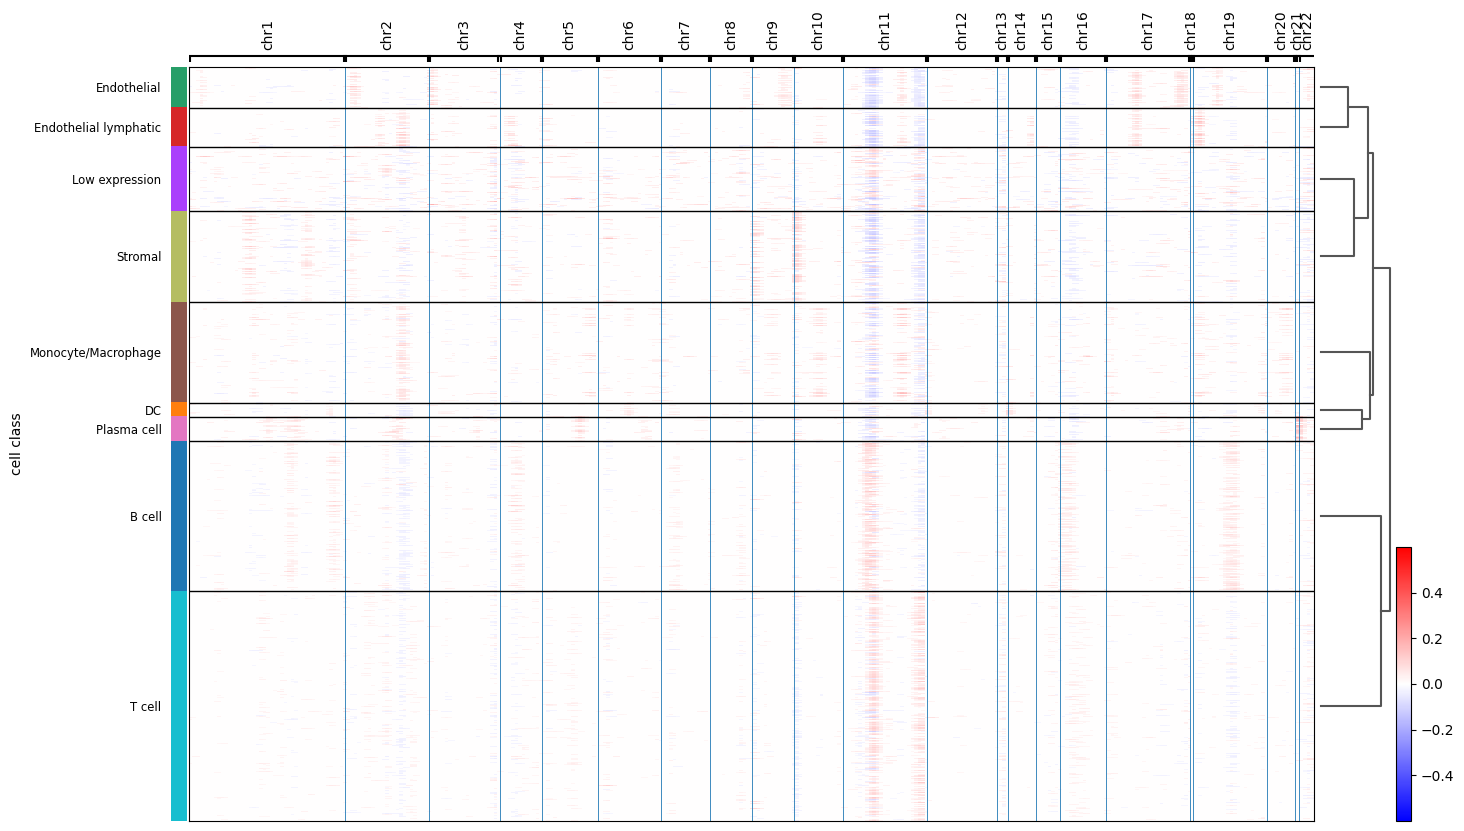

In [7]:
cnv.pl.chromosome_heatmap(adata, groupby="cell class",dendrogram=True,vmax=0.6,vmin=-0.6)

In [8]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

/home/sergio/.local/lib/python3.10/site-packages/infercnvpy/tl/__init__.py:24: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return sc.tl.leiden(


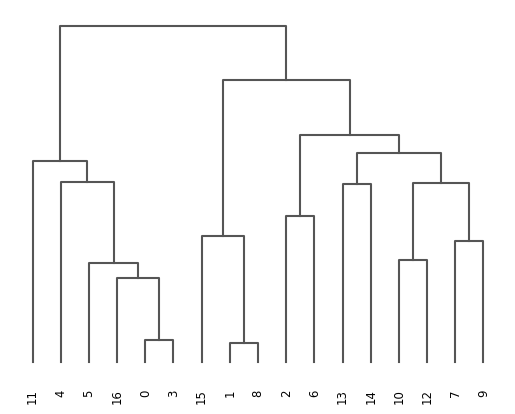

<Axes: >

In [9]:
cnv.tl.leiden(adata,resolution=0.7)
sc.tl.dendrogram(adata,groupby='cnv_leiden')
sc.pl.dendrogram(adata,groupby='cnv_leiden')

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'one', 'period', 'r', 'seven', 'six', 'space', 'three', 'two', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 66, 70, 71, 72, 75, 76, 79, 81, 85, 89, 3228]
INFO:fontTools.subset:Closed glyph list over 'MATH': 26 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 

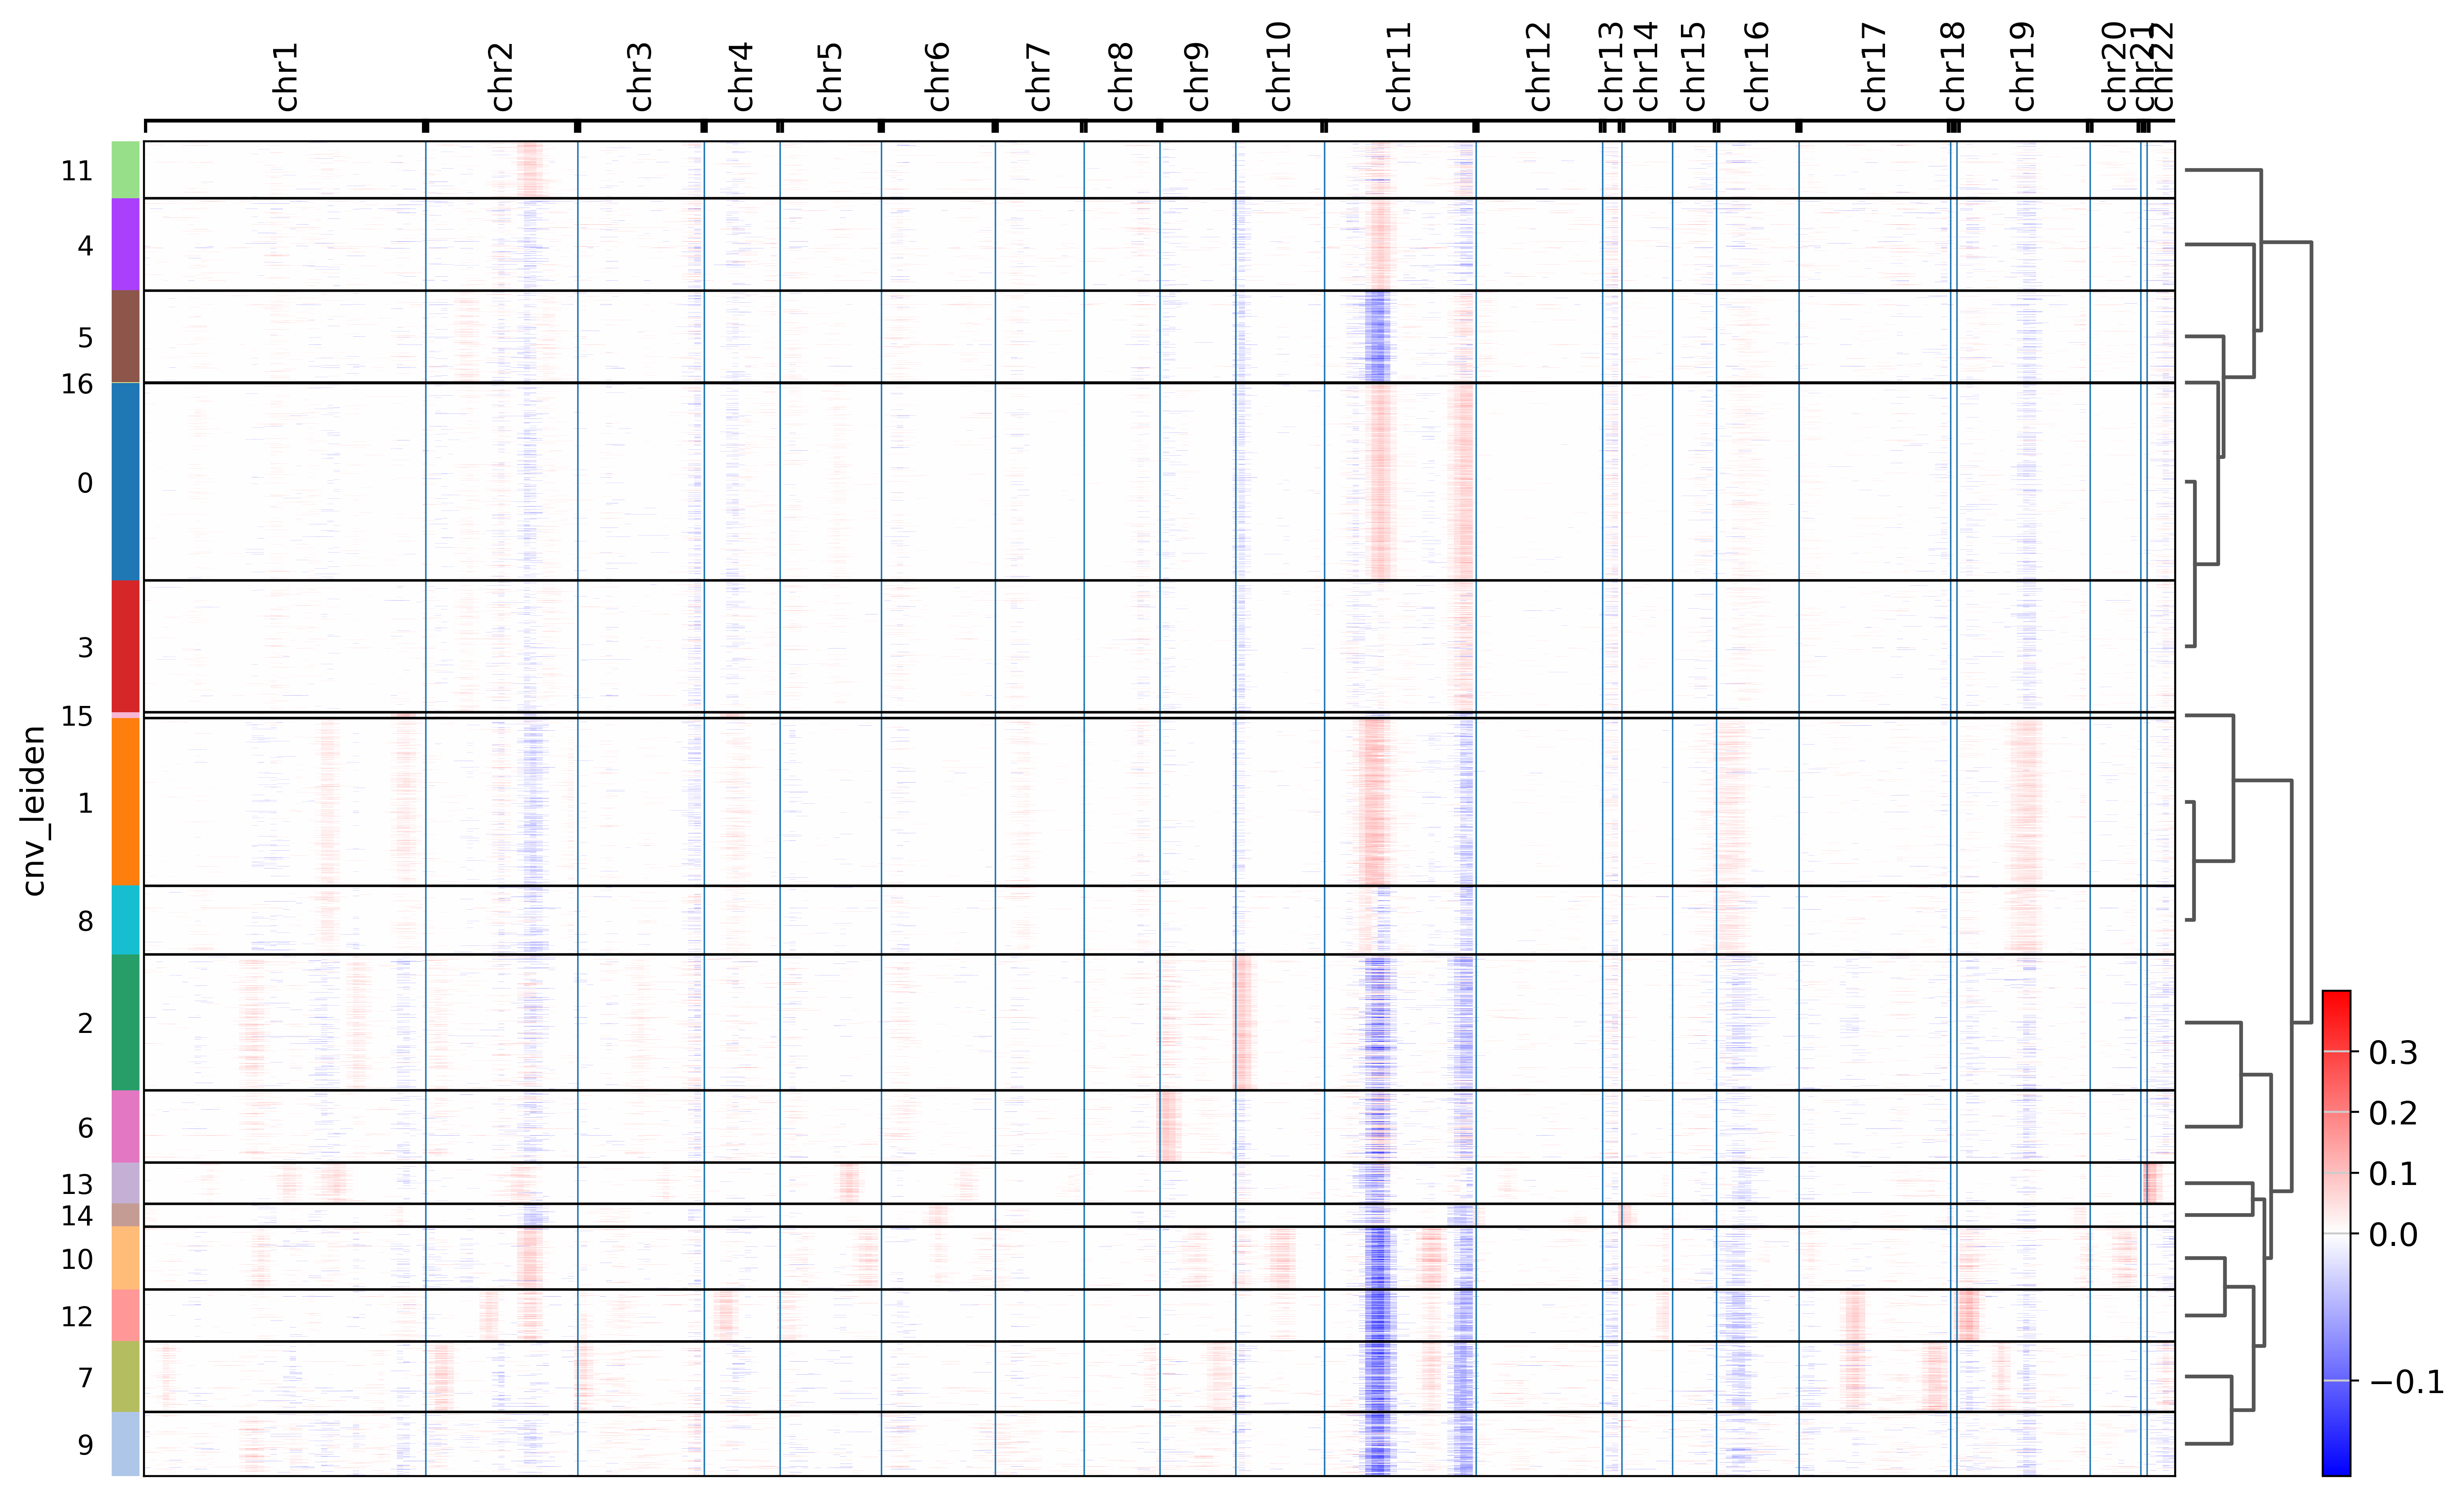

In [10]:

sc.set_figure_params(scanpy=True, dpi=200, dpi_save=200, frameon=False, vector_friendly=True, fontsize=13, figsize=(5,5), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden",dendrogram=True,vmax=0.4,show=False)
plt.savefig(saving_path+'/heatmap_cnv_leiden_moments.pdf')

/home/sergio/.local/lib/python3.10/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
... storing 'cnv_leiden' as categorical


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 25 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'one', 'period', 'r', 'seven', 'six', 'space', 'three', 'two', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 66, 70, 71, 72, 75, 76, 79, 81, 85, 89]
INFO:fontTools.subset:Closed glyph list over 'MATH': 25 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 'l', 'n', 'nine

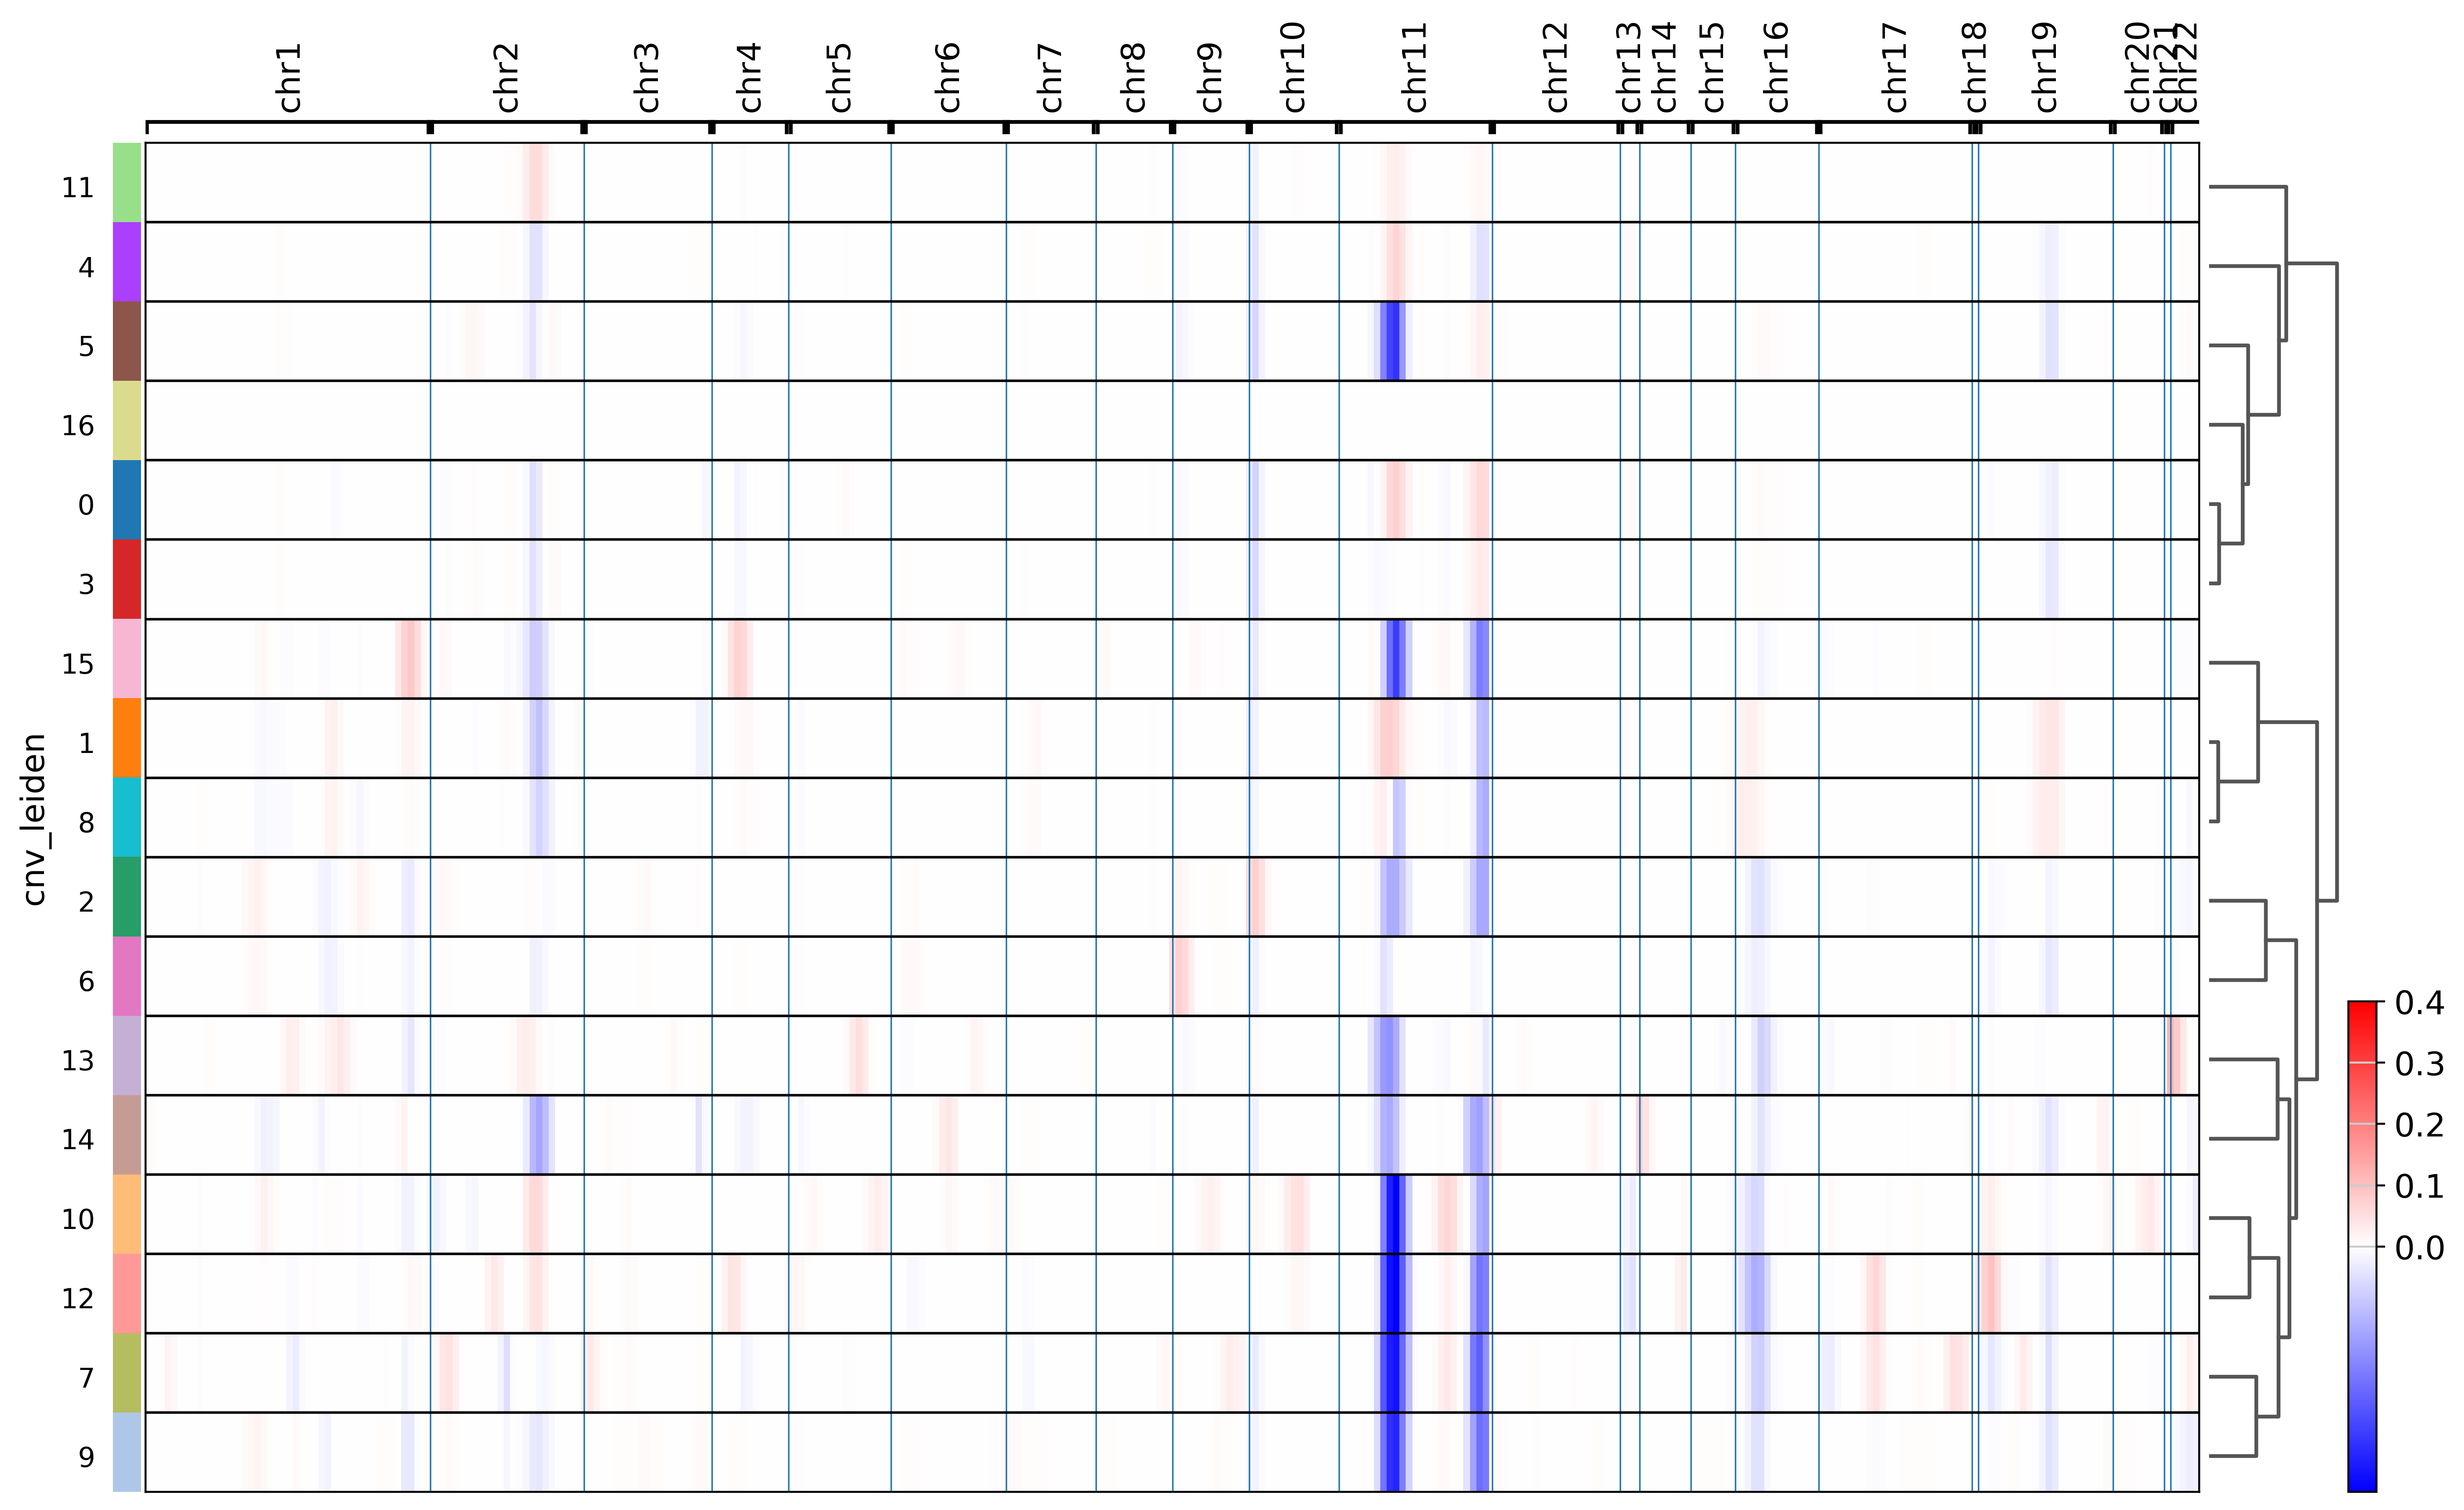

In [11]:
import matplotlib
sc.set_figure_params(scanpy=True, dpi=200, dpi_save=200, frameon=False, vector_friendly=True, fontsize=13, figsize=(5,5), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
cnv.pl.chromosome_heatmap_summary(adata, groupby="cnv_leiden",dendrogram=True,vmax=0.4,show=False)
plt.savefig(saving_path+'/heatmap_summary_cnv_leiden_moments.pdf')

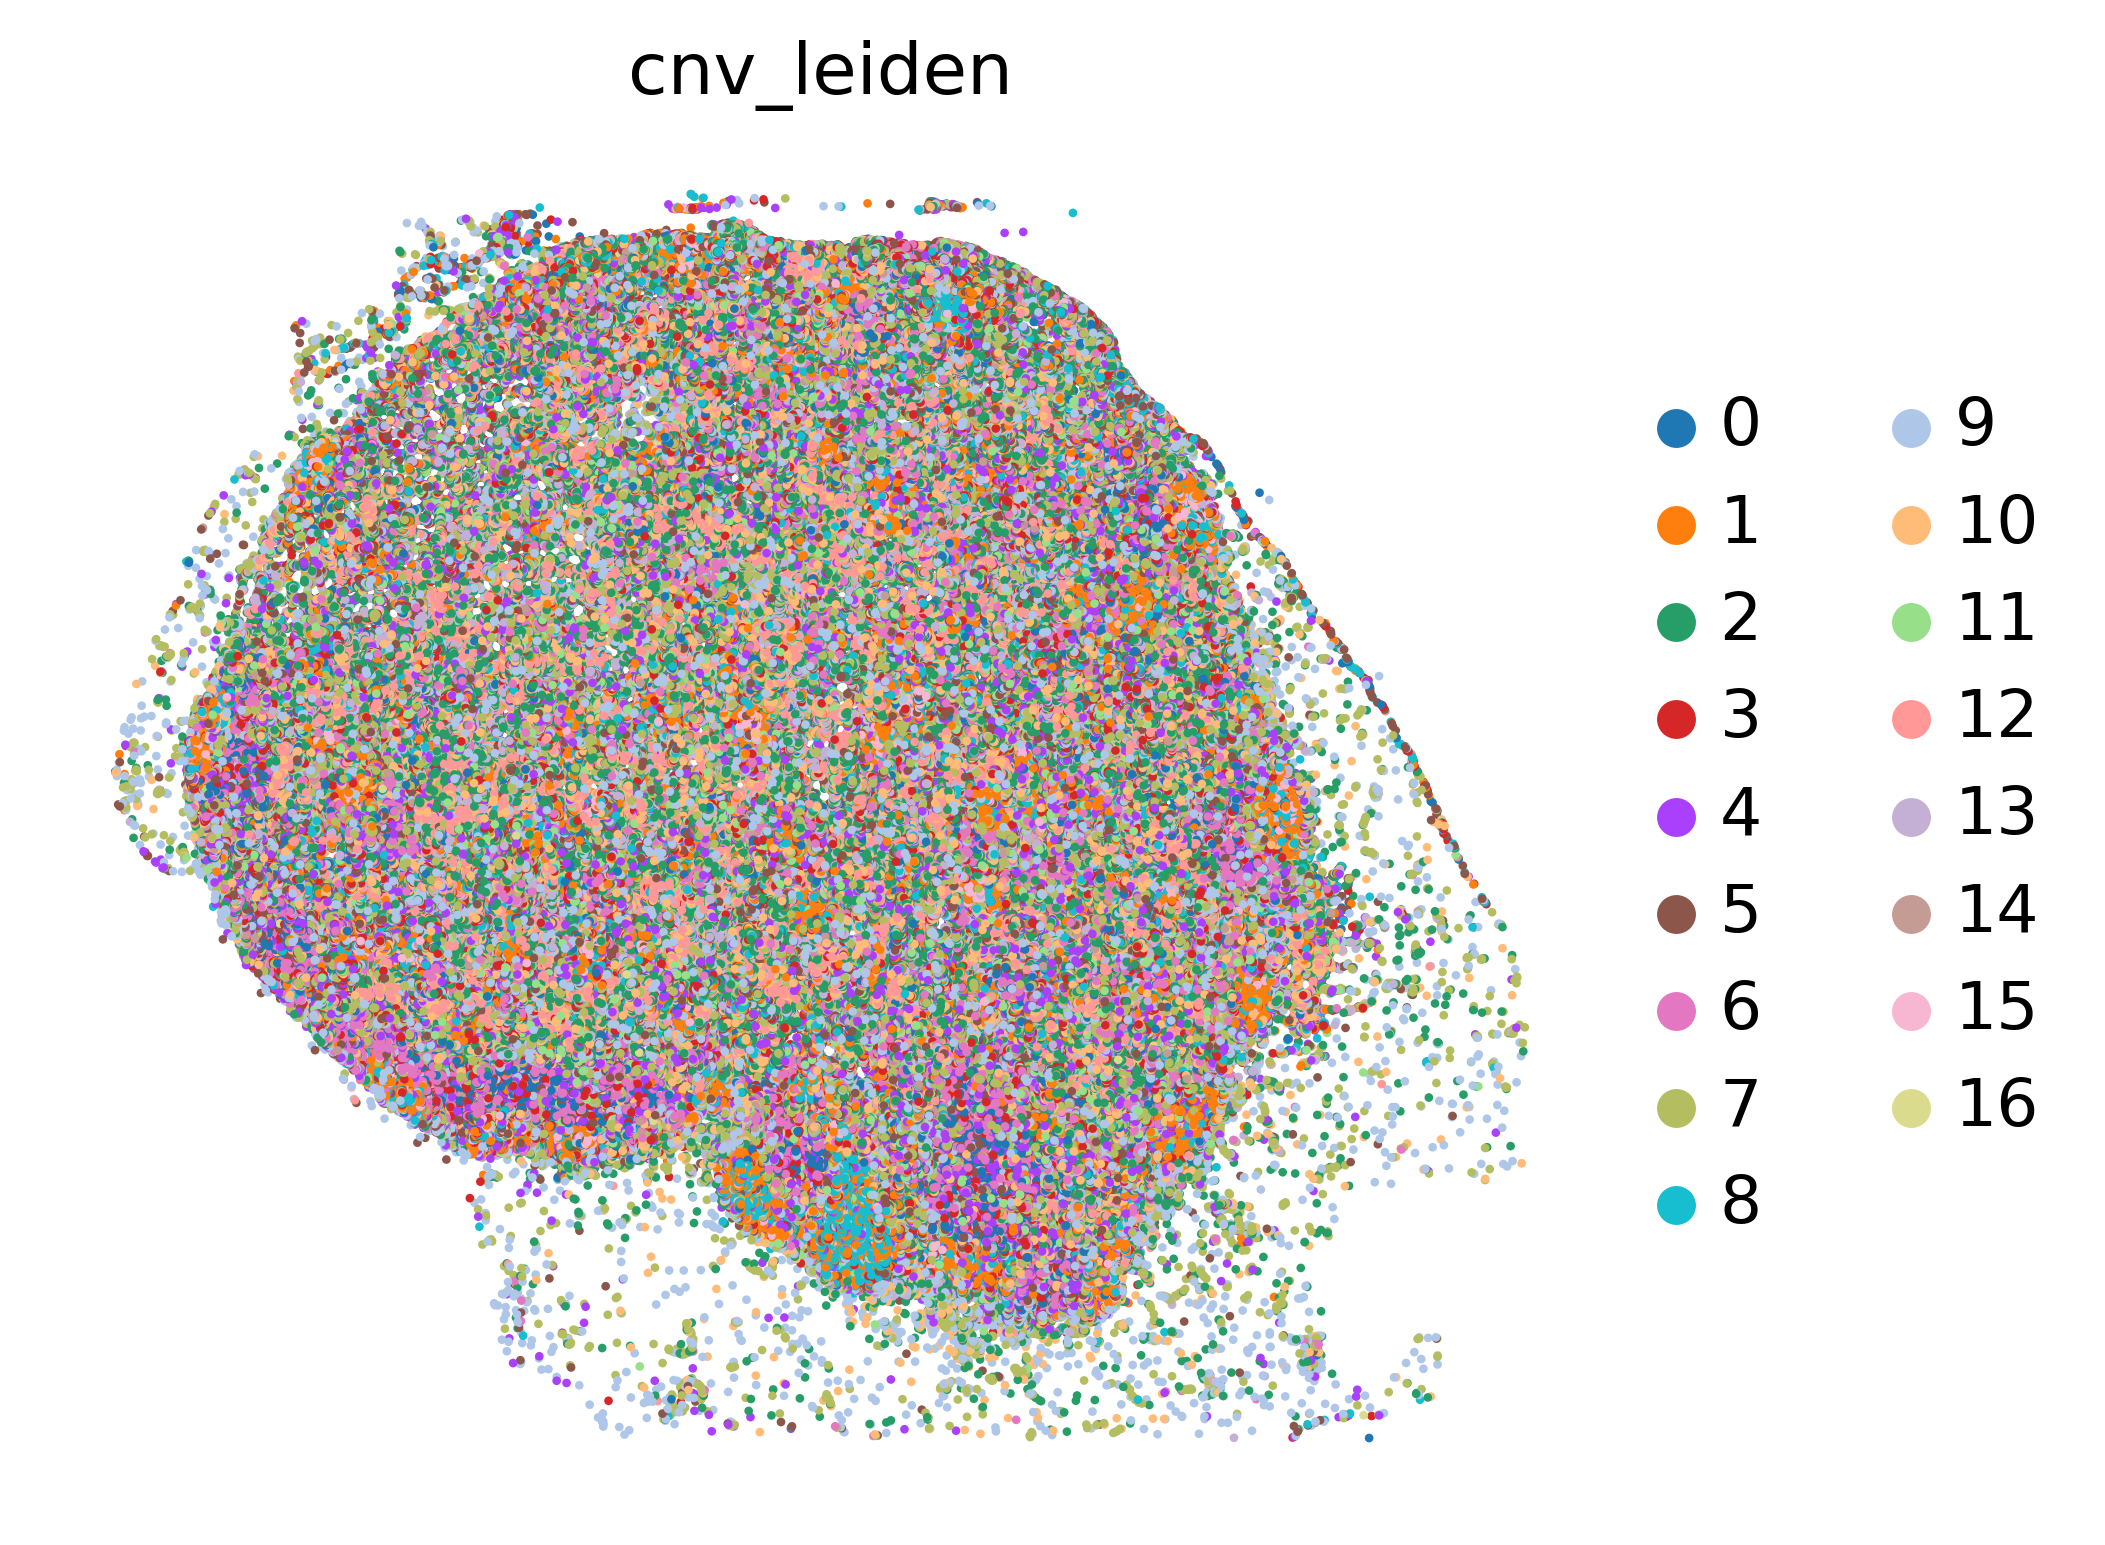

<Figure size 1000x1000 with 0 Axes>

In [12]:
import matplotlib
sc.set_figure_params(scanpy=True, dpi=200, dpi_save=200, frameon=False, vector_friendly=True, fontsize=13, figsize=(5,5), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.pl.spatial(adata,color='cnv_leiden',spot_size=50,frameon=False)
plt.savefig(saving_path+'/spatial_cnv_leiden_moments.pdf')

In [13]:
adata.write(os.path.join(saving_path,'/media/sergio/Ymir/5kovarian_for_cnv/adata_moments_cnvinfered.h5ad'))

# VERY RELEVANT 
TAP1, TAP2 and CFB are all present in the same locus. (6p21.3) -Interferon

While the same occurs for IFIT1 and IFIT3 (10q23.31) - MHC

GATA4 and SFRP1 are located in 8p and could also generate the CNV we observe in cnv cluster 8

In [ ]:
sc.tl.rank_genes_groups(adata,groupby='cnv_leiden')